In [2]:
from PIL import Image
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD, Adam
import os
from tqdm import tqdm_notebook
%matplotlib inline
from sklearn.utils import shuffle
from keras.models import load_model
from keras.utils import np_utils
from glob import glob
from keras import applications
from keras.preprocessing.image import ImageDataGenerator 
from keras import optimizers
from keras.models import Sequential,Model,load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D,GlobalAveragePooling2D
from keras.callbacks import TensorBoard,ReduceLROnPlateau,ModelCheckpoint

Using TensorFlow backend.


In [3]:
#identify images path for future use
PATH = "/Users/My_Drive/Desktop/amliNet/Data"
#load the csv file to load targets
df = pd.read_csv(PATH + "/train.csv")
df=df.sample(1000)

In [4]:
# csv file has different image path, we change to math to our directory

def edit_urls(url):
    pieces = url.split('/')
    newurl=''
    for i, piece in enumerate(pieces):
        if i>0:
            newurl += '/' + piece
        elif i==0:
            newurl += PATH
    return newurl

/Users/My_Drive/Desktop/amliNet/Data/train/patient43648/study5/view1_frontal.jpg


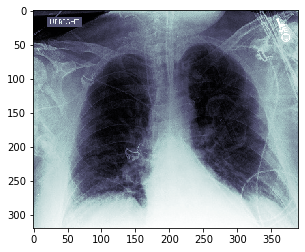

In [5]:
#testing
tester_url = edit_urls(df.iloc[0]['Path'])
print( tester_url )
xray = Image.open(tester_url)
plt.imshow(xray, cmap="bone")
plt.show()

In [6]:
#Change the path for all images
df["Path"] = df["Path"].apply(edit_urls)

In [7]:
#identify what features will be used for model training
outcomes = ['No Finding',
       'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
       'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
       'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture',
       'Support Devices'
]
#fill missing values with zeros, and assign all unsertain values (-1) to positive (1)
df[outcomes] = df[outcomes].fillna(0)
df[outcomes] = df[outcomes].replace(-1, 1)

In [7]:
#Train/test split
image_train, image_test, label_train, label_test = train_test_split(
   df['Path'], df[outcomes], test_size=0.2, random_state=42)

#Create train and test dataframes
train_df = pd.concat([image_train, label_train], axis=1)
test_df = pd.concat([image_test, label_test], axis=1)

#For the classifier to work, for some reason it has to be in string format
test_df['No Finding'] = test_df['No Finding'].apply(str)
train_df['No Finding'] = train_df['No Finding'].apply(str)

In [8]:
datagen=ImageDataGenerator(rescale=1./255,
                           shear_range=0.2,
                           zoom_range=0.2,
                           horizontal_flip=True) #scale the color information to 0 to 1 instead of 0 to 255

train_generator = datagen.flow_from_dataframe(
    train_df,
    x_col='Path',
    y_col='No Finding',
    color_mode='grayscale',
    target_size=(256, 256),
    class_mode='binary')

test_generator = datagen.flow_from_dataframe(
    test_df, 
    x_col='Path',
    y_col='No Finding',
    target_size=(256, 256),
    color_mode='grayscale',
    class_mode='binary', 
    batch_size=32)

Found 178731 validated image filenames belonging to 2 classes.
Found 44683 validated image filenames belonging to 2 classes.


In [12]:
resnet_model = applications.resnet50.ResNet50(weights= None, include_top=False, input_shape= (256,256,1))
x = resnet_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)

predictions = Dense(1, activation= 'softmax')(x)
model = Model(inputs = resnet_model.input, outputs = predictions)


adam = Adam(lr=0.0001)
model.compile(optimizer= adam, loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit_generator(train_generator,
                    steps_per_epoch=32,
                    epochs=3,
                    validation_data=test_generator,
                    validation_steps=5)

Epoch 1/3
28/32 [=========================>....] - ETA: 2:50 - loss: 14.4478 - acc: 0.0938